# Analyzing Meridians Artblocks

## Get the meridians

In [1]:
import requests
from helpers import *

OPENSEA_URL = "https://api.opensea.io/api/v1/assets"
MERIDIAN_IDS = list(range(163000000, 163001000))


def get_meridians():
    querystring = {
        "asset_contract_address": "0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270",
    }
    assets = []
    for token_ids in chunks(MERIDIAN_IDS, 20):
        print(".", end="")
        querystring["token_ids"] = token_ids
        response = requests.request("GET", OPENSEA_URL, params=querystring)
        response.raise_for_status()
        assets.extend(response.json()["assets"])
    print(f" -- All {len(assets)} assets retrieved.")
    return assets

# FIXME Turn into a generator?

meridians = get_meridians()

.................................................. -- All 1000 assets retrieved.


## Build a dataframe

In [53]:
import pandas as pd
import numpy as np
from functools import reduce
import operator

traits = [
    "Chromaticity",
    "Frequency",
    "Palette",
    "Structure",
    "Style",
    "Zoom",
]

_tt = []
for m in meridians:
    prob_score = (
        reduce(operator.mul, [t["trait_count"] / 1000 for t in m["traits"]], 1) * 1000
    )
    price = np.nan
    if m["sell_orders"] is not None:
        so = m["sell_orders"][0]
        price = float(so["current_price"]) / 10 ** int(
            so["payment_token_contract"]["decimals"]
        )
        # FIXME Also get the currency's name
    last_price = np.nan
    if m["last_sale"] is not None:
        ls = m["last_sale"]
        last_price = float(ls["total_price"]) / 10 ** int(
            ls["payment_token"]["decimals"]
        )

    _tt.append(
        [
            m["name"].split("#")[1],
            m["name"],
            price,
            last_price,
            prob_score,
            *[  # All the traits:
                t["value"].split(":")[1]
                for t in sorted(m["traits"], key=lambda x: x["value"])
                if ":" in t["value"]
            ],
            m["permalink"],
        ]
    )


df = pd.DataFrame(_tt)
df.columns = [
    "ID",
    "Name",
    "Price",
    "Lastprice",
    "Probscore",
    *traits,
    "Link",
]
df = df.set_index("ID").sort_values("Lastprice", ascending=False)


In [76]:
list(df[trait].value_counts())

[352, 295, 226, 127]

In [88]:
from IPython.display import display, HTML

for trait in traits:
    display(
        pd.DataFrame(df[trait].value_counts(normalize=False, sort=True, ascending=True)).transpose()
    )


,Monochrome,Trichrome,Polychrome,Duochrome
Chromaticity,127,226,295,352


,High,Gradual,Low,Standard
Frequency,57,213,239,491


,Glacier,Cave,Mesa,Shore,Prairie,Marsh,Ridge,Delta,Atoll,Volcano,Esker,Gulf,Canyon,Archipelago,Peninsula,Reef,Dune,Cove,Fjord,Moraine,Oasis,Other
Palette,14,15,15,17,17,17,18,18,19,19,19,19,21,21,21,22,22,23,25,26,27,585


,Variable,Uniform
Structure,192,808


,Prime,Topographic,Charcoal,Newsprint,Invert,Lino,Screenprint,Watercolour,Gilded,Polarized,Procedural,Gouache,Prismatic,Paletted
Style,8,8,9,12,13,20,21,22,27,32,60,99,262,407


,Far,Medium,Close
Zoom,326,327,347


,Name,Price,Lastprice,Probscore,Chromaticity,Frequency,Palette,Structure,Style,Zoom,Link
ID,,,,,,,,,,,
666,Meridian #666,NaN,16.0,0.098417,Duochrome,Standard,Peninsula,Variable,Paletted,Close,https://opensea.io/assets/0xa7d8d9ef8d8ce8992d...


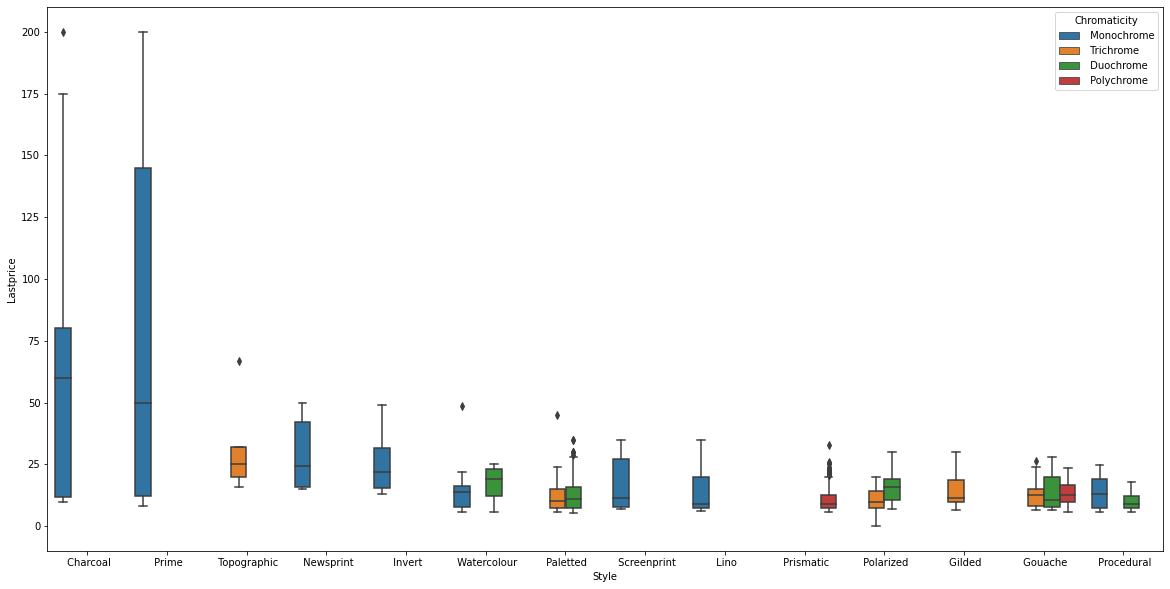

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 10)
pd.set_option("display.max_columns", None)
pd.plotting.register_matplotlib_converters()

sns.boxplot(x=df.Style, y=df.Lastprice, hue=df.Chromaticity)
df.groupby("Style").nunique()


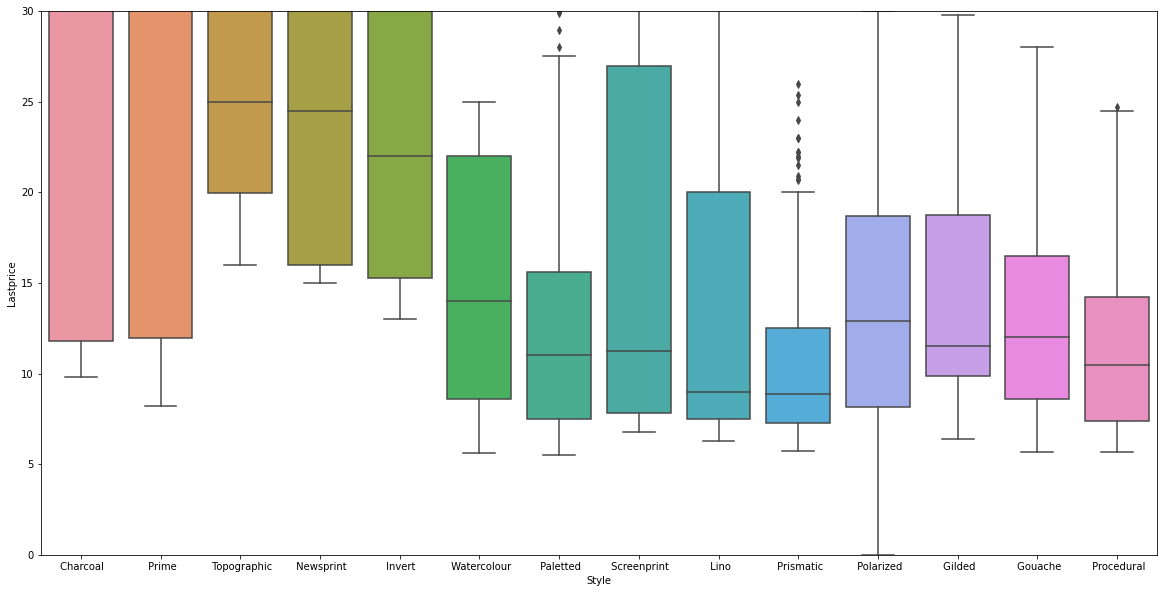

In [24]:
ax = sns.boxplot(x=df.Style, y=df.Lastprice)
_ = ax.set(ylim=(0, 30))

array([' Charcoal', ' Prime', ' Topographic', ' Newsprint', ' Invert',
       ' Watercolour', ' Paletted', ' Screenprint', ' Lino', ' Prismatic',
       ' Polarized', ' Gilded', ' Gouache', ' Procedural'], dtype=object)

In [40]:
import plotly.express as px
fig = px.box(df, x="Style", y="Lastprice", color="Chromaticity")
fig.show()


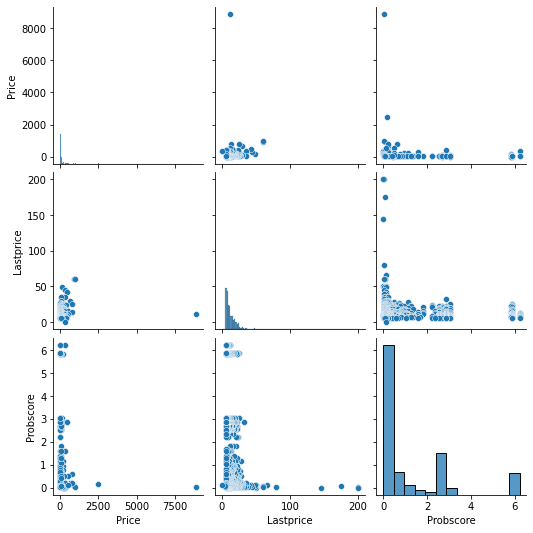

In [17]:
sns.pairplot(df)